In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import signal
import openpyxl
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_true- y_pred))) 

In [2]:
PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)

In [3]:
df = np.array(df)
pv = df[:,0]
pv = pv.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
pv = scaler.fit_transform(pv)

X, Y = create_dataset(pv, 30, 1)
print(X.shape)
print(Y.shape)

#Training_set = X[0:21447]
#Test_set = X[21448:]

(30616, 30, 1)
(30616, 1, 1)


In [5]:
trX = X[:21470, :, :].reshape(-1,30)
teX = X[21470:, :, :].reshape(-1,30)
trY = Y[:21470, :, :].reshape(-1,1)
teY = Y[21470:, :, :].reshape(-1,1)
print(trX.shape)

(21470, 30)


In [6]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [7]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
print("initial params")
params = gp.get_params()
print(params)

initial params
{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 + Matern(length_scale=2, nu=1.5), 'kernel__k2': WhiteKernel(noise_level=1), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': Matern(length_scale=2, nu=1.5), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__length_scale': 2, 'kernel__k1__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel__k1__k2__nu': 1.5, 'kernel__k2__noise_level': 1, 'kernel__k2__noise_level_bounds': (1e-05, 100000.0), 'kernel': 1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 2, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


In [8]:
for i in range(10):
    gp.fit(trX[2147*i:2147*i+2146,:], trY[2147*i:2147*i+2146,:])
    print("%.1f ended" % i)
print("learned kernel params")
print(gp.kernel_.get_params())

0.0 ended
1.0 ended
2.0 ended
3.0 ended
4.0 ended
5.0 ended
6.0 ended
7.0 ended
8.0 ended
9.0 ended
learned kernel params
{'k1': 0.00927**2 + Matern(length_scale=6.54, nu=1.5), 'k2': WhiteKernel(noise_level=0.00241), 'k1__k1': 0.00927**2, 'k1__k2': Matern(length_scale=6.54, nu=1.5), 'k1__k1__constant_value': 8.586035655577619e-05, 'k1__k1__constant_value_bounds': (1e-05, 100000.0), 'k1__k2__length_scale': 6.543231224043952, 'k1__k2__length_scale_bounds': (1e-05, 100000.0), 'k1__k2__nu': 1.5, 'k2__noise_level': 0.0024082922704900525, 'k2__noise_level_bounds': (1e-05, 100000.0)}


In [9]:
predictions, sigma = gp.predict(teX, return_std=True)
print(predictions.shape)

(9146, 1)


(9146, 1)
Test RMSE: 0.062
Test MAE: 0.033


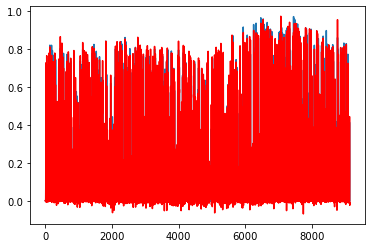

In [10]:
predictions = np.array(predictions)
print(predictions.shape)
rmse_result = root_mean_squared_error(teY, predictions)
mae_result = mae(teY, predictions)


print('Test RMSE: %.3f' % rmse_result)
print('Test MAE: %.3f' % mae_result)


plt.plot(teY)
plt.plot(predictions, color='red')
plt.show()
np.savetxt('Gaussian_PREDICTION_point.txt', predictions)